## **Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('train_dataset.csv')
df_val  = pd.read_csv('validation_dataset.csv')

## **BERT**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score

# Splitting df
train_texts = df['reviewText'].tolist()  # Extracting 'reviewText' column
train_labels = df['overall'].tolist()    # Extracting 'overall' column

# Splitting df_val
val_texts = df_val['reviewText'].tolist()
val_labels = df_val['overall'].tolist()

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
max_seq_length = 512  # Choose an appropriate value for your data

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings.input_ids),
                              torch.tensor(train_encodings.attention_mask),
                              torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_encodings.input_ids),
                            torch.tensor(val_encodings.attention_mask),
                            torch.tensor(val_labels))

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

# Store predictions and true labels for each epoch
all_val_preds_epoch = []
all_val_true_epoch = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_train:
        input_ids, attention_mask, labels = (t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar_train.set_postfix(train_loss=total_train_loss / len(progress_bar_train))

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_true = []
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids, attention_mask, labels = (t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_true.extend(labels.cpu().numpy())

            progress_bar_val.set_postfix(val_loss=total_val_loss / len(progress_bar_val))

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(all_val_true, all_val_preds)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')

    # Append predictions and true labels for each epoch
    all_val_preds_epoch.append(all_val_preds)
    all_val_true_epoch.append(all_val_true)


# Save the model and tokenizer
model.save_pretrained('./bert_model_sentiment_analysis')
tokenizer.save_pretrained('./bert_model_sentiment_analysis')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 125/125 [00:34<00:00,  3.66batch/s, val_loss=0.835]


Epoch 1:
  Train Loss: 1.0017
  Validation Loss: 0.8348
  Accuracy: 0.6450


Epoch 2/10: 100%|██████████| 125/125 [00:33<00:00,  3.68batch/s, val_loss=0.862]


Epoch 2:
  Train Loss: 0.7475
  Validation Loss: 0.8618
  Accuracy: 0.6350


Epoch 3/10: 100%|██████████| 125/125 [00:33<00:00,  3.68batch/s, val_loss=0.983]


Epoch 3:
  Train Loss: 0.5392
  Validation Loss: 0.9829
  Accuracy: 0.6600


Epoch 4/10: 100%|██████████| 125/125 [00:34<00:00,  3.67batch/s, val_loss=1.19]


Epoch 4:
  Train Loss: 0.4067
  Validation Loss: 1.1934
  Accuracy: 0.6410


Epoch 5/10: 100%|██████████| 125/125 [00:34<00:00,  3.65batch/s, val_loss=1.65]


Epoch 5:
  Train Loss: 0.3014
  Validation Loss: 1.6459
  Accuracy: 0.6400


Epoch 6/10: 100%|██████████| 125/125 [00:34<00:00,  3.66batch/s, val_loss=2.02]


Epoch 6:
  Train Loss: 0.2231
  Validation Loss: 2.0186
  Accuracy: 0.6200


Epoch 7/10: 100%|██████████| 125/125 [00:33<00:00,  3.68batch/s, val_loss=2.2]


Epoch 7:
  Train Loss: 0.1712
  Validation Loss: 2.2047
  Accuracy: 0.6040


Epoch 8/10: 100%|██████████| 125/125 [00:34<00:00,  3.67batch/s, val_loss=2.46]


Epoch 8:
  Train Loss: 0.1121
  Validation Loss: 2.4581
  Accuracy: 0.6250


Epoch 9/10: 100%|██████████| 125/125 [00:33<00:00,  3.68batch/s, val_loss=2.49]


Epoch 9:
  Train Loss: 0.1117
  Validation Loss: 2.4890
  Accuracy: 0.6430


Epoch 10/10: 100%|██████████| 125/125 [00:33<00:00,  3.68batch/s, val_loss=2.71]


Epoch 10:
  Train Loss: 0.0849
  Validation Loss: 2.7123
  Accuracy: 0.6470


('./bert_model_sentiment_analysis/tokenizer_config.json',
 './bert_model_sentiment_analysis/special_tokens_map.json',
 './bert_model_sentiment_analysis/vocab.txt',
 './bert_model_sentiment_analysis/added_tokens.json')

## **Line Chart**

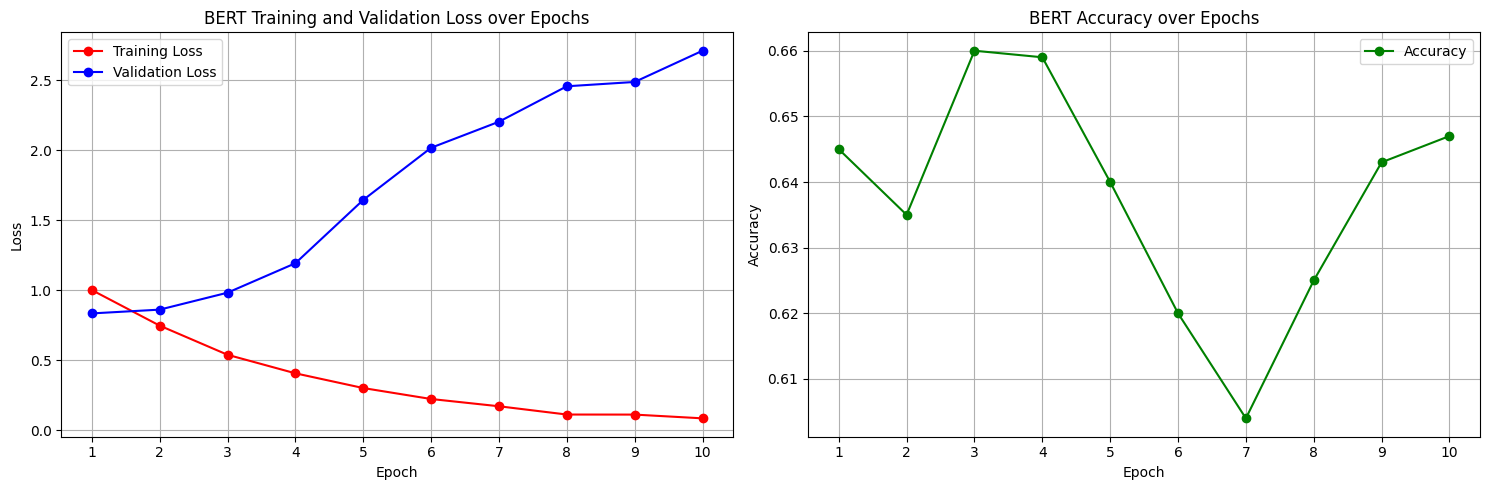

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, 11)
training_loss = [1.0017, 0.7475, 0.5392, 0.4067, 0.3014, 0.2231, 0.1712, 0.1121, 0.1117, 0.0849]
validation_loss = [0.8348, 0.8618, 0.9829, 1.1934, 1.6459, 2.0186, 2.2047, 2.4581, 2.4890, 2.7123]
accuracy = [0.6450, 0.6350, 0.6600, 0.6590, 0.6400, 0.6200, 0.6040, 0.6250, 0.6430, 0.6470]

# Plotting
plt.figure(figsize=(15, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, marker='o', label='Training Loss', color='red')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss', color='blue')
plt.title('BERT Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')
plt.title('BERT Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **Classification Report for each Epoch**

In [ ]:
from sklearn.metrics import classification_report

# Iterate over each epoch
for epoch_index in range(num_epochs):
    # Calculate classification report for the current epoch
    report = classification_report(all_val_true_epoch[epoch_index], all_val_preds_epoch[epoch_index])

    # Print the classification report for the current epoch
    print(f'Classification Report for Epoch {epoch_index + 1}:\n{report}\n')


Classification Report for Epoch 1:
              precision    recall  f1-score   support

           0       0.51      0.42      0.46        43
           1       0.48      0.26      0.34        46
           2       0.45      0.46      0.46       117
           3       0.50      0.41      0.45       254
           4       0.74      0.84      0.79       540

    accuracy                           0.64      1000
   macro avg       0.54      0.48      0.50      1000
weighted avg       0.62      0.64      0.63      1000


Classification Report for Epoch 2:
              precision    recall  f1-score   support

           0       0.61      0.33      0.42        43
           1       0.40      0.41      0.41        46
           2       0.48      0.42      0.45       117
           3       0.53      0.38      0.44       254
           4       0.76      0.91      0.82       540

    accuracy                           0.67      1000
   macro avg       0.56      0.49      0.51      1000
weight

In [ ]:
import pandas as pd
import numpy as np

# Convert the predicted values list to a numpy array
predicted_values = np.array(all_val_preds_epoch[1])

# Add the predicted values as a new column to the validation DataFrame
df_val['predicted_values'] = predicted_values

# Save the DataFrame to a CSV file
df_val.to_csv('BERT_validation_with_predictions_final.csv', index=False)

